In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

## 1. Packages

In [3]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import scipy
import glob
from datetime import datetime
from datetime import date
from datetime import timedelta
from matplotlib import animation
#import datetime
from scipy.signal import find_peaks
from numpy.polynomial import Polynomial as P
from scipy import fftpack
from scipy import signal
import pickle

'Functions from local module:'
import tools_V13 as tl

## 2. Data

### 2.1 Data from drifters

In [4]:
def read_drifters(dir, file_dict, box):

    delta = datetime(1970, 1, 1) - datetime(1950, 1, 1)
    file_dd = dir+file_dict
    handle=open(file_dd,'rb') #open the file in binary
    dd = pickle.load(handle) #process whereby a Python object hierarchy is converted into a byte stream
    handle.close()

    inds = np.where( (dd['lonmax']>box[0] ) &( dd['lonmin']<box[1] )& (dd['latmax']>box[2] ) &( dd['latmin']<box[3] ) &(dd['tmax']>=box[4])&(dd['tmin']<box[5]) )[0]
    np_p = np.sum(dd['nind'][inds])
    
    
    lon=np.empty((np_p))
    lat=np.empty((np_p))
    time=np.empty((np_p))
    u=np.empty((np_p))
    v=np.empty((np_p))
    id=np.empty((np_p))

    istart=0
    for iid in range(len(inds)):
        nl = dd['nind'][inds[iid]]
        i0 = dd['ind0'][inds[iid]]
        i1 = dd['ind1'][inds[iid]]
        #file = dir+"/drifter_"+dd['id'][inds[iid]]+".nc"#use this when the id of the drifter has not the word 'drifter'
        file = dir+dd['id'][inds[iid]]+".nc"
        fid = Dataset(file, 'r')
        fid.variables['time'].set_auto_mask(False)
        fid.variables['longitude'].set_auto_mask(False)
        fid.variables['latitude'].set_auto_mask(False)
        fid.variables['vn'].set_auto_mask(False)
        fid.variables['ve'].set_auto_mask(False)

        time[istart:istart+nl] = np.array(fid.variables['time'][0,i0:i1+1])/ 86400. + delta.days
        lon[istart:istart+nl] = np.array(fid.variables['longitude'][0,i0:i1+1])
        lat[istart:istart+nl] = np.array(fid.variables['latitude'][0,i0:i1+1])
        u[istart:istart+nl] = np.array(fid.variables['ve'][0,i0:i1+1])
        v[istart:istart+nl] = np.array(fid.variables['vn'][0,i0:i1+1])
        id[istart:istart+nl] = iid
        istart += nl
    

    inds2 = np.where((np.abs(u)<2.) & (np.abs(v)<2.) & (lon>box[0] ) &( lon<box[1] ) & (lat>box[2] ) &( lat<box[3] ) & (time>=box[4]) & (time<box[5]) )[0]
    u = u[inds2]
    v = v[inds2]
    time = time[inds2]
    lon = lon[inds2]
    lat = lat[inds2]
    id = id[inds2]

    return u, v, time, lon, lat, id

hide_toggle()

In [5]:
date_i = 25202 # Initial date 2019-01-01, this value corresponds to number of days from 1950 that is the reference time in the dictionay of drifters files
date_f = 25567 # Final date 2019-12-31, this value corresponds to number of days from 1950 that is the reference time in the dictionay of drifters files

box = [-48,-38,49,59, date_i, date_f]

glon = np.arange(box[0],box[1]+0.25,0.25)
glat = np.arange(box[2],box[3]+0.25,0.25)
gtime = np.arange(box[4], box[5],(1/24))



In [6]:
uo0, vo0, time0, lon0, lat0, id0 = read_drifters('/home/silvatol/Documents/Stage/Data/Drifters/', 'dict_coords_drogued_luz.bin', [glon[0],glon[-1], glat[0], glat[-1],gtime[0] ,gtime[-1]])

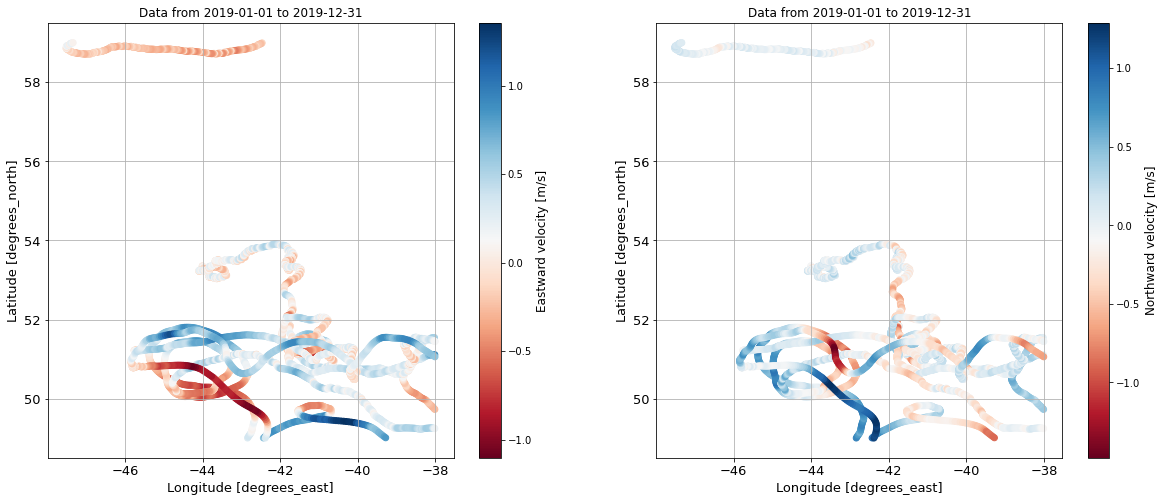

In [8]:
fig, ((ax1, ax2)) = plt.subplots(1,2)
fig.set_size_inches(20, 8)


fig1 = ax1.scatter(lon0, lat0,c = uo0,cmap='RdBu')
cbar = fig.colorbar(fig1,ax=ax1)
cbar.ax.set_ylabel('Eastward velocity [m/s]',fontsize=12)
ax1.set_title("Data from 2019-01-01 to 2019-12-31")
ax1.set_ylabel('Latitude [degrees_north]',fontsize=13)
ax1.set_xlabel('Longitude [degrees_east]',fontsize=13)
ax1.tick_params(labelsize=13)
ax1.grid('on')


fig2 = ax2.scatter(lon0, lat0,c = vo0,cmap='RdBu')
cbar = fig.colorbar(fig2,ax=ax2)
cbar.ax.set_ylabel('Northward velocity [m/s]',fontsize=12)
ax2.set_title("Data from 2019-01-01 to 2019-12-31")
ax2.set_ylabel('Latitude [degrees_north]',fontsize=13)
ax2.set_xlabel('Longitude [degrees_east]',fontsize=13)
ax2.tick_params(labelsize=13)
ax2.grid('on')

plt.savefig('Drifters.jpg', bbox_inches='tight')

hide_toggle()

### 2.2 Data from ERA5

In [10]:
fnU = '/home/silvatol/Documents/Stage/Data/Era5_wind/adaptor.mars.internal-1620120648.6625023-27390-24-7499d5d9-70ba-4ac3-af6f-0059ceed689d.nc'
dsU= xr.open_dataset(fnU)

fnV = '/home/silvatol/Documents/Stage/Data/Era5_wind/adaptor.mars.internal-1620120668.6755376-3925-6-75313d93-4f8b-4c04-ab25-5f863797c757.nc'
dsV= xr.open_dataset(fnV)

In [11]:
# Data from each data frame. Selection of study point and period 
time = dsU.time
lat = dsU.latitude.values
lon = dsU.longitude.values
U10 = dsU.u10n.sel(time=slice('2019-01-01','2019-12-31'))
V10 = dsV.v10n.sel(time=slice('2019-01-01','2019-12-31'))

#U10i = U10.sel(longitude=-45).sel(latitude=55).interp(time=pd.date_range("2018-08-31T00:00:00.000000000", "2019-01-12T23:00:00.000000000", periods=58320))
#V10i = V10.interp(time=pd.date_range("2018-08-31T00:00:00.000000000", "2019-01-12T23:00:00.000000000", periods=58320))

### 2.2 Geostrophic data

In [12]:
def read_cgeos(dir, box):
    #gtime = numpy.arange(numpy.floor(box[4])-1,numpy.ceil(box[5])+1+1,1.)
    gtime = np.arange(np.floor(box[4]),np.ceil(box[5])+1,1.) #I modify this from the original to have 365 days
    for it in range(len(gtime)):
        date=datetime(1950, 1, 1)+timedelta(days=gtime[it])
        file = glob.glob(dir+"dt_global_allsat_phy_l4_"+"{:02d}".format(date.year)+"{:02d}".format(date.month)+"{:02d}".format(date.day)+"_*.nc")[0]
        with Dataset(file, 'r') as fcid:
            if it==0:
                # glon = np.mod(numpy.array(fcid.variables['longitude'][:])+180,360)-180
                # ii = np.argsort(glon)
                # glon=glon[ii]
                glon = np.mod(np.array(fcid.variables['longitude'][:])+180,360)-180
                iblock1 = np.where((glon<0))[0]
                iblock2 = np.where((glon>=0))[0]
                glon=np.concatenate((glon[iblock1],glon[iblock2]))
                glat = np.array(fcid.variables['latitude'][:])
                ix0=min(np.where(glon>=box[0])[0]) -1
                ix1=max(np.where(glon<=box[1])[0]) +3
                iy0=min(np.where(glat>=box[2])[0]) -1
                iy1=max(np.where(glat<=box[3])[0]) +3
                glon = glon[ix0:ix1]
                glat = glat[iy0:iy1]
                UG=np.zeros((len(gtime),len(glat),len(glon)))
                VG=np.zeros((len(gtime),len(glat),len(glon)))
                SLA=np.zeros((len(gtime),len(glat),len(glon)))
            
            UG[it,:,:]=np.concatenate((np.array(fcid.variables['ugos'][0,:,iblock1[0]:iblock1[-1]+1]),np.array(fcid.variables['ugos'][0,:,iblock2[0]:iblock2[-1]+1])),axis=1)[iy0:iy1,ix0:ix1]     
            VG[it,:,:]=np.concatenate((np.array(fcid.variables['vgos'][0,:,iblock1[0]:iblock1[-1]+1]),np.array(fcid.variables['vgos'][0,:,iblock2[0]:iblock2[-1]+1])),axis=1)[iy0:iy1,ix0:ix1]      
            SLA[it,:,:]=np.concatenate((np.array(fcid.variables['sla'][0,:,iblock1[0]:iblock1[-1]+1]),np.array(fcid.variables['sla'][0,:,iblock2[0]:iblock2[-1]+1])),axis=1)[iy0:iy1,ix0:ix1]

            #UG[it,:,:] = np.array(fcid.variables['ugos'][0,iy0:iy1,ix0:ix1])
            #VG[it,:,:] = np.array(fcid.variables['vgos'][0,iy0:iy1,ix0:ix1])
            #SLA[it,:,:] = np.array(fcid.variables['sla'][0,iy0:iy1,ix0:ix1])
    UG[(UG>5)|(UG<-5)]=np.nan
    VG[(VG>5)|(VG<-5)]=np.nan
    SLA[(SLA>5)|(SLA<-5)]=np.nan
    
    finterpUG = scipy.interpolate.RegularGridInterpolator([gtime,glat,glon],UG,bounds_error=True)
    finterpVG = scipy.interpolate.RegularGridInterpolator([gtime,glat,glon],VG,bounds_error=True)
    # finterpSLA = scipy.interpolate.RegularGridInterpolator([gtime,glat,glon],SLA,bounds_error=True,fill_value=None)

    return finterpUG, finterpVG

hide_toggle()

In [13]:
finterpUG,finterpVG = read_cgeos('/home/silvatol/Documents/Stage/Data/geos/', [glon[0],glon[-1], glat[0], glat[-1],gtime[0] ,gtime[-1]])

IndexError: list index out of range

In [13]:
Ug = finterpUG(np.transpose([time0,lat0,lon0]))
Vg = finterpVG(np.transpose([time0,lat0,lon0]))

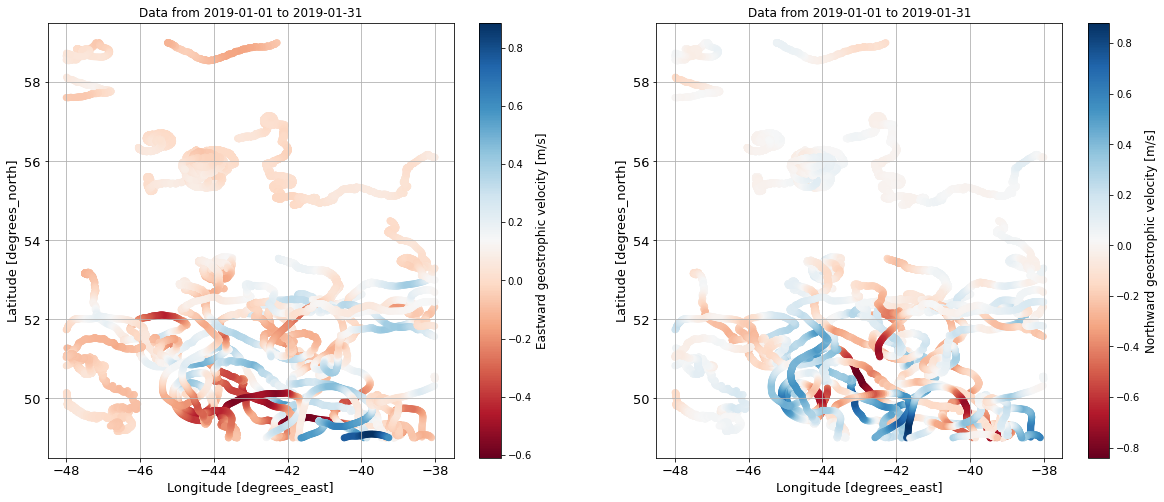

In [14]:
fig, ((ax1, ax2)) = plt.subplots(1,2)
fig.set_size_inches(20, 8)


fig1 = ax1.scatter(lon0, lat0,c = Ug,cmap='RdBu')
cbar = fig.colorbar(fig1,ax=ax1)
cbar.ax.set_ylabel('Eastward geostrophic velocity [m/s]',fontsize=12)
ax1.set_title("Data from 2019-01-01 to 2019-01-31")
ax1.set_ylabel('Latitude [degrees_north]',fontsize=13)
ax1.set_xlabel('Longitude [degrees_east]',fontsize=13)
ax1.tick_params(labelsize=13)
ax1.grid('on')


fig2 = ax2.scatter(lon0, lat0,c = Vg,cmap='RdBu')
cbar = fig.colorbar(fig2,ax=ax2)
cbar.ax.set_ylabel('Northward geostrophic velocity [m/s]',fontsize=12)
ax2.set_title("Data from 2019-01-01 to 2019-01-31")
ax2.set_ylabel('Latitude [degrees_north]',fontsize=13)
ax2.set_xlabel('Longitude [degrees_east]',fontsize=13)
ax2.tick_params(labelsize=13)
ax2.grid('on')

#plt.savefig('Drifters.jpg', bbox_inches='tight')

hide_toggle()

### 2.3 Ageostrophic component

In [15]:
Uag = uo0-Ug
Vag = vo0-Vg

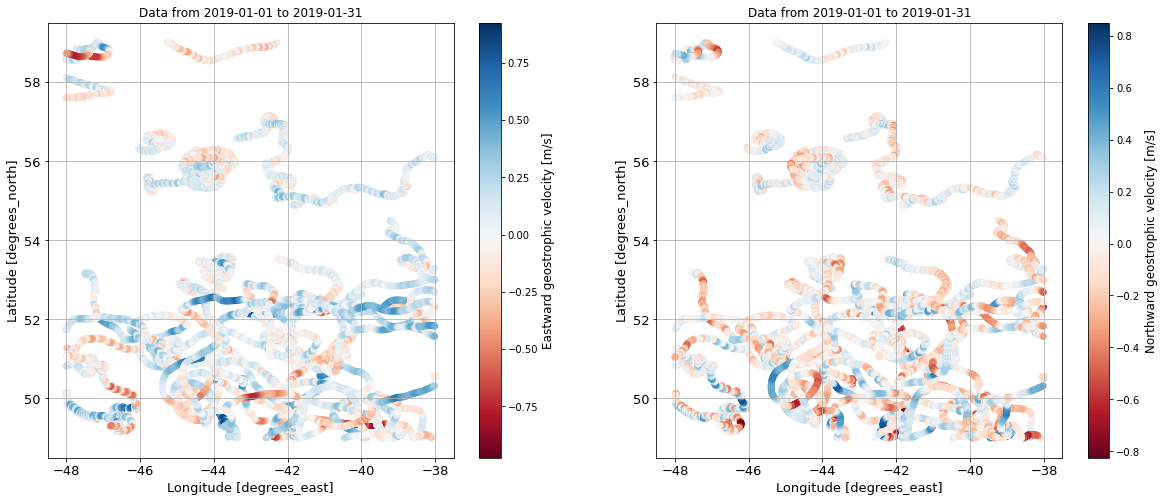

In [16]:
fig, ((ax1, ax2)) = plt.subplots(1,2)
fig.set_size_inches(20, 8)


fig1 = ax1.scatter(lon0, lat0,c = Uag,cmap='RdBu')
cbar = fig.colorbar(fig1,ax=ax1)
cbar.ax.set_ylabel('Eastward geostrophic velocity [m/s]',fontsize=12)
ax1.set_title("Data from 2019-01-01 to 2019-01-31")
ax1.set_ylabel('Latitude [degrees_north]',fontsize=13)
ax1.set_xlabel('Longitude [degrees_east]',fontsize=13)
ax1.tick_params(labelsize=13)
ax1.grid('on')


fig2 = ax2.scatter(lon0, lat0,c = Vag,cmap='RdBu')
cbar = fig.colorbar(fig2,ax=ax2)
cbar.ax.set_ylabel('Northward geostrophic velocity [m/s]',fontsize=12)
ax2.set_title("Data from 2019-01-01 to 2019-01-31")
ax2.set_ylabel('Latitude [degrees_north]',fontsize=13)
ax2.set_xlabel('Longitude [degrees_east]',fontsize=13)
ax2.tick_params(labelsize=13)
ax2.grid('on')

#plt.savefig('Drifters.jpg', bbox_inches='tight')

hide_toggle()

## 3. Results from 1D model

In [17]:
# Definition of grid for computations with the 1D model
lonc = np.arange(box[0],box[1]+0.25,0.25)
latc = np.arange(box[2],box[3]+0.25,0.25)
timec = np.arange(box[4], box[5],(1/24))

# Time variables
dtime1= 200/86400
day = 364.99
save_data1 = int((1/24)/dtime1) #Save data each hour

In [18]:
# Wind array according to the study zone
U10c = np.zeros((len(lonc),len(latc),int(day/dtime1)+5))
V10c = np.zeros_like(U10c)

for i in range(0,len(lonc)):
    for j in range(0,len(latc)):
        U10c[i,j,:] = U10.sel(longitude=lon[i]).sel(latitude=lat[j]).interp(time=pd.date_range("2016-01-01T00:00:00.000000000", "2016-12-31T23:00:00.000000000", periods=157680))
        V10c[i,j,:] = V10.sel(longitude=lon[i]).sel(latitude=lat[j]).interp(time=pd.date_range("2016-01-01T00:00:00.000000000", "2016-12-31T23:00:00.000000000", periods=157680))

W = np.sqrt((U10c**2)+(V10c**2))

In [19]:
# Definition of levels
z1 = np.linspace(300,0,301) # Levels
H_V1 = np.diff(z1)/2 + z1[0:z1.shape[0]-1] #Heights at wich velocities are computed
z1_plots = np.max(z1)-H_V1
z1n = np.linspace(0.5,299.5,29900) # To interpolate results from 1D model results to avoid have a very small Deltaz
n_layer = np.where(z1n==z1n.flat[np.abs(z1n - 15).argmin()]) #To find the nearest position of depth around 15 m (drifter depth values)

# Definition of eddy viscosity (kappa)
K1 = np.zeros(z1.shape[0]-1)
K1[:] = 0.0015

### 3.1 Results using constant eddy viscosity 1.5e-04

In [20]:
Urcel = np.load("/home/silvatol/Documents/Stage/Codes/7. 1DModel_Drifters/2016/TXT/Ur_300m_300L_200s_l-48-38_lat49-59_ce_1.5e-04_2016.npy")
Vrcel = np.load("/home/silvatol/Documents/Stage/Codes/7. 1DModel_Drifters/2016/TXT/Vr_300m_300L_200s_l-48-38_lat49-59_ce_1.5e-04_2016.npy")
trcel = np.load("/home/silvatol/Documents/Stage/Codes/7. 1DModel_Drifters/2016/TXT/tr_300m_300L_200s_l-48-38_lat49-59_ce_1.5e-04_2016.npy")

In [21]:
finterpUcel = scipy.interpolate.RegularGridInterpolator([lonc,latc,trcel],Urcel,bounds_error=True)
finterpVcel = scipy.interpolate.RegularGridInterpolator([lonc,latc,trcel],Vrcel,bounds_error=True)

In [22]:
Ucel = finterpUcel(np.transpose([lon0,lat0,time0]))
Vcel = finterpVcel(np.transpose([lon0,lat0,time0]))

### 3.2 Results using constant eddy viscosity 1.5e-03 

In [23]:
Urce = np.load("/home/silvatol/Documents/Stage/Codes/7. 1DModel_Drifters/2016/TXT/Ur_300m_300L_200s_l-48-38_lat49-59_ce_1.5e-03_2016.npy")
Vrce = np.load("/home/silvatol/Documents/Stage/Codes/7. 1DModel_Drifters/2016/TXT/Vr_300m_300L_200s_l-48-38_lat49-59_ce_1.5e-03_2016.npy")
trce = np.load("/home/silvatol/Documents/Stage/Codes/7. 1DModel_Drifters/2016/TXT/tr_300m_300L_200s_l-48-38_lat49-59_ce_1.5e-03_2016.npy")

In [24]:
finterpUce = scipy.interpolate.RegularGridInterpolator([lonc,latc,trce],Urce,bounds_error=True)
finterpVce = scipy.interpolate.RegularGridInterpolator([lonc,latc,trce],Vrce,bounds_error=True)

In [25]:
Uce = finterpUce(np.transpose([lon0,lat0,time0]))
Vce = finterpVce(np.transpose([lon0,lat0,time0]))

### 3.3 Results using constant eddy viscosity 1.5e-02

In [26]:
Urceh = np.load("/home/silvatol/Documents/Stage/Codes/7. 1DModel_Drifters/2016/TXT/Ur_300m_300L_200s_l-48-38_lat49-59_ce1.5e-02_2016.npy")
Vrceh = np.load("/home/silvatol/Documents/Stage/Codes/7. 1DModel_Drifters/2016/TXT/Vr_300m_300L_200s_l-48-38_lat49-59_ce1.5e-02_2016.npy")
trceh = np.load("/home/silvatol/Documents/Stage/Codes/7. 1DModel_Drifters/2016/TXT/tr_300m_300L_200s_l-48-38_lat49-59_ce1.5e-02_2016.npy")

In [27]:
finterpUceh = scipy.interpolate.RegularGridInterpolator([lonc,latc,trceh],Urceh,bounds_error=True)
finterpVceh = scipy.interpolate.RegularGridInterpolator([lonc,latc,trceh],Vrceh,bounds_error=True)

In [28]:
Uceh = finterpUceh(np.transpose([lon0,lat0,time0]))
Vceh = finterpVceh(np.transpose([lon0,lat0,time0]))

### 3.4 Results using constant eddy viscosity 1.5e-01

In [29]:
Urcehh = np.load("/home/silvatol/Documents/Stage/Codes/7. 1DModel_Drifters/2016/TXT/Ur_300m_300L_200s_l-48-38_lat49-59_ce1.5e-01_2016.npy")
Vrcehh = np.load("/home/silvatol/Documents/Stage/Codes/7. 1DModel_Drifters/2016/TXT/Vr_300m_300L_200s_l-48-38_lat49-59_ce1.5e-01_2016.npy")
trcehh = np.load("/home/silvatol/Documents/Stage/Codes/7. 1DModel_Drifters/2016/TXT/tr_300m_300L_200s_l-48-38_lat49-59_ce1.5e-01_2016.npy")

In [30]:
finterpUcehh = scipy.interpolate.RegularGridInterpolator([lonc,latc,trcehh],Urcehh,bounds_error=True)
finterpVcehh = scipy.interpolate.RegularGridInterpolator([lonc,latc,trcehh],Vrcehh,bounds_error=True)

In [31]:
Ucehh = finterpUcehh(np.transpose([lon0,lat0,time0]))
Vcehh = finterpVcehh(np.transpose([lon0,lat0,time0]))

### 3.4 Adjust of data for comparisons

In [32]:
# time0 to dates
dates = []
import datetime as dttime
for i,ti in enumerate(time0):
    dayss = ti
    dates.append(dttime.timedelta(dayss)+dttime.datetime(year=1950,month=1,day=1))

In [33]:
# Wind array according to the study zone for plots
U10p = np.zeros((len(lonc),len(latc),int((day+0.01)*24)+24))
V10p = np.zeros_like(U10p)

for i in range(0,len(lonc)):
    for j in range(0,len(latc)):
        U10p[i,j,:] = U10.sel(longitude=lonc[i]).sel(latitude=latc[j]).sel(time=slice("2016-01-01T00:00:00.000000000", "2016-12-31T23:00:00.000000000"))
        V10p[i,j,:] = V10.sel(longitude=lonc[i]).sel(latitude=latc[j]).sel(time=slice("2016-01-01T00:00:00.000000000", "2016-12-31T23:00:00.000000000"))

Wp = np.sqrt((U10p**2)+(V10p**2))

print("Wind for plots")

hide_toggle()

Wind for plots


In [34]:
# Interpolation of wind for the drifters points for plots
finterpU10 = scipy.interpolate.RegularGridInterpolator([lonc,latc,trcehh],U10p[:,:,0:8760],bounds_error=True)
finterpV10 = scipy.interpolate.RegularGridInterpolator([lonc,latc,trcehh],V10p[:,:,0:8760],bounds_error=True)

U10wp = finterpU10(np.transpose([lon0,lat0,time0]))
V10wp = finterpV10(np.transpose([lon0,lat0,time0]))
W10wp = np.sqrt((U10wp**2)+(V10wp**2))

In [35]:
# Choosing points that are continuous over time 
ensit = np.concatenate(([-1],np.where((np.diff(time0)<0)|(np.diff(time0)>1))[0]))
di = np.zeros(len(ensit)-1)
df = np.zeros(len(ensit)-1)

print("data range pairs")
for iit in range(len(ensit)-1):
    iit0 = ensit[iit]+1
    di[iit] = iit0
    iit1 = ensit[iit+1]+1
    df[iit] = iit1 
    print('range [{}]:'.format(iit),iit0,iit1,'#points: {}'.format(iit1-iit0))

hide_toggle()

data range pairs
range [0]: 0 501 #points: 501
range [1]: 501 1406 #points: 905
range [2]: 1406 3945 #points: 2539
range [3]: 3945 4071 #points: 126
range [4]: 4071 4333 #points: 262
range [5]: 4333 4440 #points: 107
range [6]: 4440 6351 #points: 1911
range [7]: 6351 6967 #points: 616
range [8]: 6967 9945 #points: 2978
range [9]: 9945 10392 #points: 447
range [10]: 10392 10812 #points: 420
range [11]: 10812 10992 #points: 180
range [12]: 10992 11216 #points: 224
range [13]: 11216 11480 #points: 264
range [14]: 11480 12252 #points: 772
range [15]: 12252 12434 #points: 182
range [16]: 12434 12888 #points: 454
range [17]: 12888 13246 #points: 358
range [18]: 13246 13486 #points: 240
range [19]: 13486 16548 #points: 3062
range [20]: 16548 16798 #points: 250
range [21]: 16798 16887 #points: 89
range [22]: 16887 17899 #points: 1012
range [23]: 17899 18441 #points: 542
range [24]: 18441 18469 #points: 28
range [25]: 18469 18783 #points: 314
range [26]: 18783 19996 #points: 1213
range [27]: 19

## 4. Frequencies

#### <font color='red'>Range of data to use </font>

In [942]:
r = 28 #indicate the range desire to study
ii = int(di[r])
ff = int(df[r])
print(lat0[ii])
print(lat0[ff])

55.575401306152344
49.00429916381836


In [902]:
import sys,os,shutil
import pdb
import scipy 
from math import pi
from scipy.fftpack import fft

def psd1d(hh=None,dx=1.,tap=0.05, detrend=True):

    hh=hh-np.mean(hh)
    nx=np.shape(hh)[0]

    if detrend:
        hh=scipy.signal.detrend(hh)

    if tap>0:
        ntaper = np.int(tap * nx + 0.5)
        taper = np.zeros(nx)+1.
    
        taper[:ntaper] = np.cos(np.arange(ntaper)/(ntaper-1.)*pi/2+3*pi/2)
        taper[-ntaper:] = np.cos(-np.arange(-ntaper+1,1)/(ntaper-1.)*pi/2+3*pi/2)
        hh=hh*taper

    ss=fft(hh)

    ff=np.arange(1,nx/2-1)/(nx*dx)
    PSD=2*dx/(nx)*np.abs(ss[1:int(nx/2-1)])**2

    return ff, PSD

hide_toggle()

In [903]:
#Inertial period
lat_r = lat0[ii:ff]

#lowest inertial period in the range
fcp_min = 2*2*np.pi/86164*np.sin(np.min(lat_r)*np.pi/180)
Tp_min = 2*np.pi/fcp_min
fi_min = (1/Tp_min)*3600


#highest inertial period in the range
fcp_max = 2*2*np.pi/86164*np.sin(np.max(lat_r)*np.pi/180)
Tp_max = 2*np.pi/fcp_max
fi_max = (1/Tp_max)*3600

print("lowest inertial frequency",fi_min)
print("highest inertial frequency",fi_max)
ts = 1 #time sampling

hide_toggle()

lowest inertial frequency 0.06864400508747635
highest inertial frequency 0.06951872140282624


In [984]:
Urce.shape
lat[20]

76.0

In [977]:
Vcomplext_d  = uo0[ii:ff]   + 1j* vo0[ii:ff]
Vcomplexag_d = Uag[ii:ff]   + 1j* Vag[ii:ff]
Vcomplexcel  = Ucel[ii:ff]  + 1j* Vcel[ii:ff]
Vcomplexce   = Uce[ii:ff]   + 1j* Vce[ii:ff]  
Vcomplexceh  = Uceh[ii:ff]  + 1j* Vceh[ii:ff]
Vcomplexcehh = Ucehh[ii:ff] + 1j* Vcehh[ii:ff]
Vcomplexcer = Urce[20,20,:] + 1j* Vrce[20,20,:]

In [978]:
# Total from drifters
ff_2t,P1_2t = psd1d(hh=Vcomplext_d,dx=ts, tap=0, detrend=True)
ff_2t,P2_2t = psd1d(hh=Vcomplext_d.conjugate() ,dx=ts,tap=0, detrend=True)

# Ageostrophic from drifters
ff_2ag,P1_2ag = psd1d(hh=Vcomplexag_d,dx=ts, tap=0, detrend=True)
ff_2ag,P2_2ag = psd1d(hh=Vcomplexag_d.conjugate() ,dx=ts,tap=0, detrend=True)

# 1D constant eddy 1.5e-04
ff_2cel,P1_2cel = psd1d(hh=Vcomplexcel,dx=ts, tap=0, detrend=True)
ff_2cel,P2_2cel = psd1d(hh=Vcomplexcel.conjugate() ,dx=ts,tap=0, detrend=True)

# 1D constant eddy 1.5e-03
ff_2ce,P1_2ce = psd1d(hh=Vcomplexce,dx=ts, tap=0, detrend=True)
ff_2ce,P2_2ce = psd1d(hh=Vcomplexce.conjugate() ,dx=ts,tap=0, detrend=True)

# 1D constant eddy 1.5e-02
ff_2ceh,P1_2ceh = psd1d(hh=Vcomplexceh,dx=ts, tap=0, detrend=True)
ff_2ceh,P2_2ceh = psd1d(hh=Vcomplexceh.conjugate() ,dx=ts,tap=0, detrend=True)

# 1D constant eddy 1.5e-01
ff_2cehh,P1_2cehh = psd1d(hh=Vcomplexcehh,dx=ts, tap=0, detrend=True)
ff_2cehh,P2_2cehh = psd1d(hh=Vcomplexcehh.conjugate() ,dx=ts,tap=0, detrend=True)

# 1D results directly eddy 1.5e-03
ff_2cer,P1_2cer = psd1d(hh=Vcomplexcer,dx=ts, tap=0, detrend=True)
ff_2cer,P2_2cer = psd1d(hh=Vcomplexcer.conjugate() ,dx=ts,tap=0, detrend=True)

print('frequency spectrum')

hide_toggle()

frequency spectrum


## 5. Velocities filter out 

In [906]:
from scipy.signal import butter, lfilter
from scipy.signal import freqz

In [907]:
# Wide band pass filter
padlen = 100
padtype = 'constant'

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    #y = lfilter(b, a, data)
    y = signal.filtfilt(b, a, data, padlen=padlen,padtype=padtype)
    return y

# Narrow band pass filter

def narrow_bandpass(w0, Q, fs=2.0):
    """w0: Frequency to be retained in a signal
    Q: Quality factor Q = w0/bw, bw= bandwidth
    fs: The sampling frequency"""
    return scipy.signal.iirpeak(w0, Q, fs=fs)

def narrow_bandpass_filter(data,w0,Q,fs=2.0):
    bn,an = narrow_bandpass(w0, Q, fs=fs)
    #yf = lfilter(bn, an, data)
    yf = signal.filtfilt(bn, an, data, padlen=padlen,padtype=padtype)
    return yf

# Notch filter

def notch(w0, Q, fs=2.0):
    """w0: Frequency to be retained in a signal
    Q: Quality factor Q = w0/bw, bw= bandwidth
    fs: The sampling frequency"""
    return scipy.signal.iirnotch(w0, Q, fs=fs)

def notch_filter(data,w0,Q,fs=2.0):
    bn,an = narrow_bandpass(w0, Q, fs=fs)
    #yf = lfilter(bn, an, data)
    yf = signal.filtfilt(bn, an, data, padlen=padlen,padtype=padtype)
    return yf

hide_toggle()

In [961]:
Q = 2
Vnarrow_Q2t    = narrow_bandpass_filter(Vcomplext_d,(fi_max+fi_min)/2,Q ,fs=1/ts)
Vnarrow_Q2ag   = narrow_bandpass_filter(Vcomplexag_d,(fi_max+fi_min)/2,Q ,fs=1/ts)
Vnarrow_Q2cel  = narrow_bandpass_filter(Vcomplexcel,(fi_max+fi_min)/2,Q ,fs=1/ts)
Vnarrow_Q2ce   = narrow_bandpass_filter(Vcomplexce,(fi_max+fi_min)/2,Q ,fs=1/ts)
Vnarrow_Q2ceh  = narrow_bandpass_filter(Vcomplexceh,(fi_max+fi_min)/2,Q ,fs=1/ts)
Vnarrow_Q2cehh = narrow_bandpass_filter(Vcomplexcehh,(fi_max+fi_min)/2,Q ,fs=1/ts)

Vnarrow_Q2t    = butter_bandpass_filter(Vcomplext_d,fi_min*0.90,fi_max*1.10,fs=1/ts,order=5)
Vnarrow_Q2ag   = butter_bandpass_filter(Vcomplext_d,fi_min*0.90,fi_max*1.10,fs=1/ts,order=5)
Vnarrow_Q2cel  = butter_bandpass_filter(Vcomplext_d,fi_min*0.90,fi_max*1.10,fs=1/ts,order=5)
Vnarrow_Q2ce   = butter_bandpass_filter(Vcomplext_d,fi_min*0.90,fi_max*1.10,fs=1/ts,order=5)
Vnarrow_Q2ceh  = butter_bandpass_filter(Vcomplext_d,fi_min*0.90,fi_max*1.10,fs=1/ts,order=5)
Vnarrow_Q2cehh = butter_bandpass_filter(Vcomplext_d,fi_min*0.90,fi_max*1.10,fs=1/ts,order=5)

In [962]:
# Total from drifters
ff_2t_nfQ2,P1_2t_nfQ2 = psd1d(hh=Vnarrow_Q2t,dx=ts, tap=0, detrend=True)
ff_2t_nfQ2,P2_2t_nfQ2 = psd1d(hh=Vnarrow_Q2t.conjugate() ,dx=ts,tap=0, detrend=True)

# Ageostrophic from drifters
ff_2ag_nfQ2,P1_2ag_nfQ2 = psd1d(hh=Vnarrow_Q2ag,dx=ts, tap=0, detrend=True)
ff_2ag_nfQ2,P2_2ag_nfQ2 = psd1d(hh=Vnarrow_Q2ag.conjugate() ,dx=ts,tap=0, detrend=True)

# 1D constant eddy 1.5e-04
ff_2cel_nfQ2,P1_2cel_nfQ2 = psd1d(hh=Vnarrow_Q2cel,dx=ts, tap=0, detrend=True)
ff_2cel_nfQ2,P2_2cel_nfQ2 = psd1d(hh=Vnarrow_Q2cel.conjugate() ,dx=ts,tap=0, detrend=True)

# 1D constant eddy 1.5e-03
ff_2ce_nfQ2,P1_2ce_nfQ2 = psd1d(hh=Vnarrow_Q2ce,dx=ts, tap=0, detrend=True)
ff_2ce_nfQ2,P2_2ce_nfQ2 = psd1d(hh=Vnarrow_Q2ce.conjugate() ,dx=ts,tap=0, detrend=True)

# 1D constant eddy 1.5e-02
ff_2ceh_nfQ2,P1_2ceh_nfQ2 = psd1d(hh=Vnarrow_Q2ceh,dx=ts, tap=0, detrend=True)
ff_2ceh_nfQ2,P2_2ceh_nfQ2 = psd1d(hh=Vnarrow_Q2ceh.conjugate() ,dx=ts,tap=0, detrend=True)

# 1D constant eddy 1.5e-01
ff_2cehh_nfQ2,P1_2cehh_nfQ2 = psd1d(hh=Vnarrow_Q2cehh,dx=ts, tap=0, detrend=True)
ff_2cehh_nfQ2,P2_2cehh_nfQ2 = psd1d(hh=Vnarrow_Q2cehh.conjugate() ,dx=ts,tap=0, detrend=True)

print('frequency spectrum after filter')

hide_toggle()

frequency spectrum after filter


In [963]:
# Getting the components
# Total from drifters
Ut_nfQ2 = Vnarrow_Q2t.real
Vt_nfQ2 = Vnarrow_Q2t.imag

# Ageostrophic from drifters

Uag_nfQ2 = Vnarrow_Q2ag.real
Vag_nfQ2 = Vnarrow_Q2ag.imag

# 1D constant eddy 1.5e-04
Ucel_nfQ2 = Vnarrow_Q2cel.real
Vcel_nfQ2 = Vnarrow_Q2cel.imag

# 1D constant eddy 1.5e-03
Uce_nfQ2 = Vnarrow_Q2ce.real
Vce_nfQ2 = Vnarrow_Q2ce.imag

# 1D constant eddy 1.5e-02
Uceh_nfQ2 = Vnarrow_Q2ceh.real
Vceh_nfQ2 = Vnarrow_Q2ceh.imag

# 1D constant eddy 1.5e-01
Ucehh_nfQ2 = Vnarrow_Q2cehh.real
Vcehh_nfQ2 = Vnarrow_Q2cehh.imag

print('Components after filtering')

hide_toggle()

Components after filtering


## 6. Comparisons

### 6.1 PSD

### 6.1.1 Before filtering

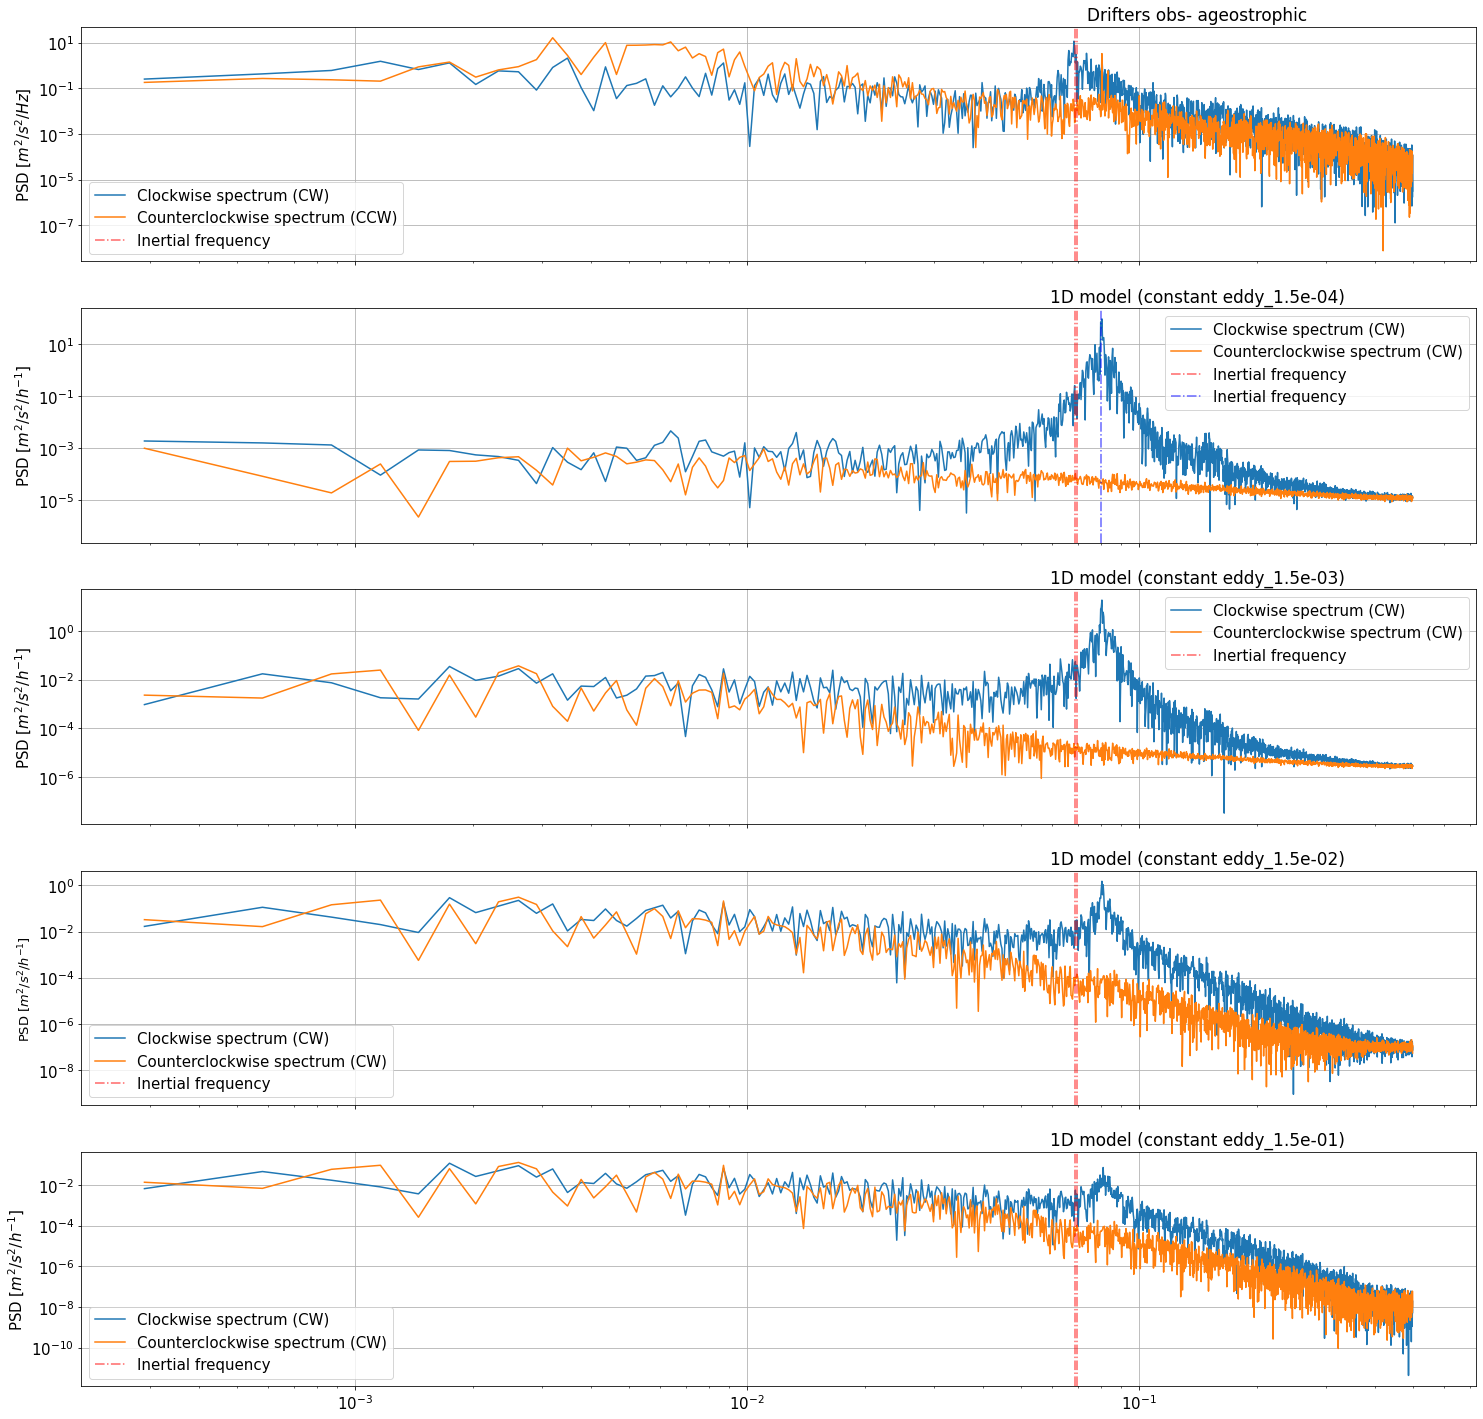

In [988]:
limitb = len(P2_2ag)

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, sharex=True)
fig.set_size_inches(25, 25)

ax1.plot(ff_2ag[0:limitb],P2_2ag[0:limitb],label='Clockwise spectrum (CW)')
ax1.plot(ff_2ag[0:limitb],P1_2ag[0:limitb],label='Counterclockwise spectrum (CCW)')
ax1.set_ylabel('PSD $[m^2/s^2/Hz]$',fontsize=15)
ax1.tick_params(labelsize=15)
ax1.text(0.80, 1.05, "Drifters obs- ageostrophic", horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=17)
ax1.axvline(x = fi_max, color = 'r',ls='-.', label = 'Inertial frequency',alpha=0.6)
ax1.axvline(x = fi_min, color = 'r',ls='-.',alpha=0.6)
ax1.legend(fontsize=15,loc='best')
ax1.grid()
ax1.set_yscale('log')
ax1.set_xscale('log')

ax2.plot(ff_2cel[0:limitb],P2_2cel[0:limitb],label='Clockwise spectrum (CW)')
ax2.plot(ff_2cel[0:limitb],P1_2cel[0:limitb],label='Counterclockwise spectrum (CW)')
ax2.set_ylabel('PSD $[m^2/s^2/h^{-1}]$',fontsize=15)
ax2.text(0.80, 1.05, "1D model (constant eddy_1.5e-04)", horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, fontsize=17)
ax2.grid()
ax2.axvline(x = fi_max, color = 'r',ls='-.', label = 'Inertial frequency',alpha=0.6)
ax2.axvline(x = fi_max*1.15, color = 'b',ls='-.', label = 'Inertial frequency',alpha=0.6)
ax2.axvline(x = fi_min, color = 'r',ls='-.',alpha=0.6)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15,loc='best')
ax2.set_yscale('log')
ax2.set_xscale('log')


ax3.plot(ff_2ce[0:limitb],P2_2ce[0:limitb],label='Clockwise spectrum (CW)')
ax3.plot(ff_2ce[0:limitb],P1_2ce[0:limitb],label='Counterclockwise spectrum (CW)')
ax3.set_ylabel('PSD $[m^2/s^2/h^{-1}]$',fontsize=15)
ax3.text(0.80, 1.05, "1D model (constant eddy_1.5e-03)", horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes, fontsize=17)
ax3.grid()
ax3.axvline(x = fi_max, color = 'r',ls='-.', label = 'Inertial frequency',alpha=0.6)
ax3.axvline(x = fi_min, color = 'r',ls='-.',alpha=0.6)
ax3.tick_params(labelsize=15)
ax3.legend(fontsize=15,loc='best')
ax3.set_yscale('log')
ax3.set_xscale('log')


ax4.plot(ff_2ceh[0:limitb],P2_2ceh[0:limitb],label='Clockwise spectrum (CW)')
ax4.plot(ff_2ceh[0:limitb],P1_2ceh[0:limitb],label='Counterclockwise spectrum (CW)')
ax4.set_ylabel('PSD $[m^2/s^2/h^{-1}]$',fontsize=13)
ax4.text(0.80, 1.05, "1D model (constant eddy_1.5e-02)", horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes, fontsize=17)
ax4.grid()
ax4.axvline(x = fi_max, color = 'r',ls='-.', label = 'Inertial frequency',alpha=0.6)
ax4.axvline(x = fi_min, color = 'r',ls='-.',alpha=0.6)
ax4.tick_params(labelsize=15)
ax4.legend(fontsize=15,loc='best')
ax4.set_yscale('log')
ax4.set_xscale('log')


ax5.plot(ff_2cehh[0:limitb],P2_2cehh[0:limitb],label='Clockwise spectrum (CW)')
ax5.plot(ff_2cehh[0:limitb],P1_2cehh[0:limitb],label='Counterclockwise spectrum (CW)')
ax5.set_ylabel('PSD $[m^2/s^2/h^{-1}]$',fontsize=15)
ax5.text(0.80, 1.05, "1D model (constant eddy_1.5e-01)", horizontalalignment='center', verticalalignment='center', transform=ax5.transAxes, fontsize=17)
ax5.grid()
ax5.axvline(x = fi_max, color = 'r',ls='-.', label = 'Inertial frequency',alpha=0.6)
ax5.axvline(x = fi_min, color = 'r',ls='-.',alpha=0.6)
ax5.tick_params(labelsize=15)
ax5.legend(fontsize=15,loc='best')
ax5.set_yscale('log')
ax5.set_xscale('log')

hide_toggle()

### 6.1.2 After filtering

In [965]:
P2_2ag.shape

(1718,)

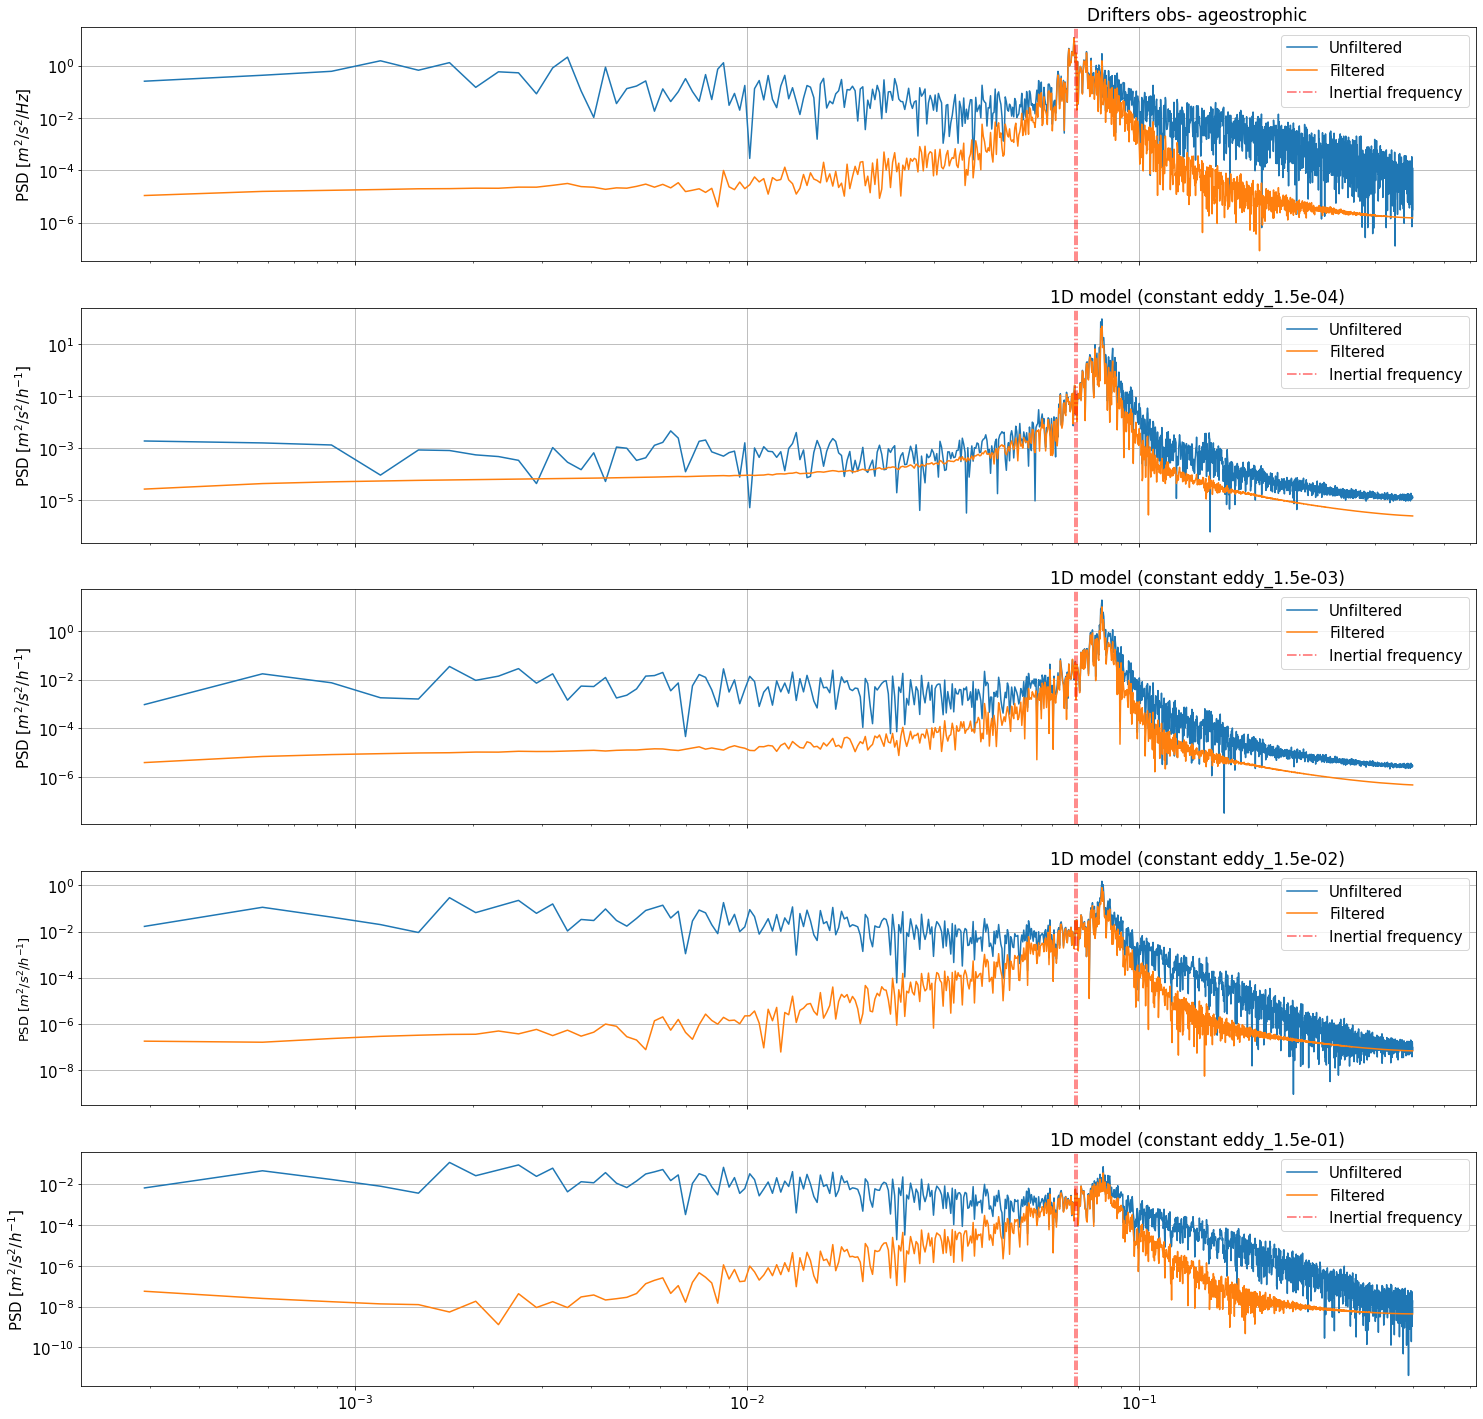

In [966]:
limit = len(P2_2ag)

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, sharex=True)
fig.set_size_inches(25, 25)

ax1.plot(ff_2ag[0:limit],P2_2ag[0:limit],label='Unfiltered')
ax1.plot(ff_2ag_nfQ2[0:limit],P2_2ag_nfQ2[0:limit],label='Filtered')
ax1.set_ylabel('PSD $[m^2/s^2/Hz]$',fontsize=15)
ax1.tick_params(labelsize=15)
ax1.text(0.80, 1.05, "Drifters obs- ageostrophic", horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, fontsize=17)
ax1.axvline(x = fi_max, color = 'r',ls='-.', label = 'Inertial frequency',alpha=0.6)
ax1.axvline(x = fi_min, color = 'r',ls='-.',alpha=0.6)
ax1.legend(fontsize=15,loc='best')
ax1.grid()
ax1.set_yscale('log')
ax1.set_xscale('log')


ax2.plot(ff_2cel[0:limit],P2_2cel[0:limit],label='Unfiltered')
ax2.plot(ff_2cel_nfQ2[0:limit],P2_2cel_nfQ2[0:limit],label='Filtered')
ax2.set_ylabel('PSD $[m^2/s^2/h^{-1}]$',fontsize=15)
ax2.text(0.80, 1.05, "1D model (constant eddy_1.5e-04)", horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, fontsize=17)
ax2.grid()
ax2.axvline(x = fi_max, color = 'r',ls='-.', label = 'Inertial frequency',alpha=0.6)
ax2.axvline(x = fi_min, color = 'r',ls='-.',alpha=0.6)
ax2.tick_params(labelsize=15)
ax2.legend(fontsize=15,loc='best')
ax2.set_yscale('log')
ax2.set_xscale('log')


ax3.plot(ff_2ce[0:limit],P2_2ce[0:limit],label='Unfiltered')
ax3.plot(ff_2ce_nfQ2[0:limit],P2_2ce_nfQ2[0:limit],label='Filtered')
ax3.set_ylabel('PSD $[m^2/s^2/h^{-1}]$',fontsize=15)
ax3.text(0.80, 1.05, "1D model (constant eddy_1.5e-03)", horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes, fontsize=17)
ax3.grid()
ax3.axvline(x = fi_max, color = 'r',ls='-.', label = 'Inertial frequency',alpha=0.6)
ax3.axvline(x = fi_min, color = 'r',ls='-.',alpha=0.6)
ax3.tick_params(labelsize=15)
ax3.legend(fontsize=15,loc='best')
ax3.set_yscale('log')
ax3.set_xscale('log')


ax4.plot(ff_2ceh[0:limit],P2_2ceh[0:limit],label='Unfiltered')
ax4.plot(ff_2ceh_nfQ2[0:limit],P2_2ceh_nfQ2[0:limit],label='Filtered')
ax4.set_ylabel('PSD $[m^2/s^2/h^{-1}]$',fontsize=13)
ax4.text(0.80, 1.05, "1D model (constant eddy_1.5e-02)", horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes, fontsize=17)
ax4.grid()
ax4.axvline(x = fi_max, color = 'r',ls='-.', label = 'Inertial frequency',alpha=0.6)
ax4.axvline(x = fi_min, color = 'r',ls='-.',alpha=0.6)
ax4.tick_params(labelsize=15)
ax4.legend(fontsize=15,loc='best')
ax4.set_yscale('log')
ax4.set_xscale('log')


ax5.plot(ff_2cehh[0:limit],P2_2cehh[0:limit],label='Unfiltered')
ax5.plot(ff_2cehh_nfQ2[0:limit],P2_2cehh_nfQ2[0:limit],label='Filtered')
ax5.set_ylabel('PSD $[m^2/s^2/h^{-1}]$',fontsize=15)
ax5.text(0.80, 1.05, "1D model (constant eddy_1.5e-01)", horizontalalignment='center', verticalalignment='center', transform=ax5.transAxes, fontsize=17)
ax5.grid()
ax5.axvline(x = fi_max, color = 'r',ls='-.', label = 'Inertial frequency',alpha=0.6)
ax5.axvline(x = fi_min, color = 'r',ls='-.',alpha=0.6)
ax5.tick_params(labelsize=15)
ax5.legend(fontsize=15,loc='best')
ax5.set_yscale('log')
ax5.set_xscale('log')

#plt.savefig('Comp_freq.spectrum_winter.jpg', bbox_inches='tight')

hide_toggle()

### 6.2 TOTAL VS AGEOSTROPHIC COMPONENT IN-SITU OBS (after filtering)

In [967]:
def plot_complex_layer_comp_drifter(Wind,List_comp,List_names,gtime,ti,tf,layers_vector):

    """This function allows to get the plots of the relation abs(U+iV) to compute the mean time for the 
    desire layers
    • Wind: vector that contains the wind values
    • List_comp: list that contains the fields to compare
    • List_names: list of fields' names
    • gtime: vector that contains all the time steps of the simulation
    • ti,tf: Desired visualization time
    • heights: vector that contains the heigth or level at which the velocities were computed
    • layer1,layer2,layer3,layer4: desire layers to plot"""
    
    #Define the ratios for the graph according to the number of plots
    ratios= []
    ratios.append(0.4)
    for i in range(1,len(layers_vector)+1):
        ratios.append(1)
   

    fig, ax = plt.subplots(len(layers_vector)+1,1,sharex=True,gridspec_kw={'height_ratios': ratios})
    fig.subplots_adjust(left = 1, bottom = 5, right = 2, top = 6, wspace = 0.7, hspace = 0.2)
    fig.set_size_inches(20,8)                  
    
    #Plot wind vector
    im0 = ax[0].plot(gtime[ti:tf],Wind[ti:tf] ,color="black", lw=1.5)
    ax[0].grid('on')
    ax[0].set_ylabel('$\parallel U_{10}\parallel$ [m/s]', fontsize=20)
    ax[0].set_xlabel('', fontsize=20)
    ax[0].tick_params(axis='y')
    ax[0].tick_params(labelsize=18)
    
    #Plot other fields for comparison
    for j,l in enumerate(layers_vector):
        for i,n in enumerate(List_comp[1::]):
            array = n
            im1 = ax[j+1].plot(gtime[ti:tf],array[ti:tf] , lw=1.7, label=List_names[i+1],alpha=0.5)
            ax[j+1].grid('on')
            ax[j+1].set_ylabel('Amplitude ($|U+iV|$) [m/s]', fontsize=20)
            ax[j+1].set_xlabel('', fontsize=20)
            ax[j+1].tick_params(axis='y')
            ax[j+1].tick_params(labelsize=18)
            ax[j+1].legend(fontsize=15)
            ax[j+1].text(0.08, 1.03, "15 m", horizontalalignment='center', verticalalignment='center', transform=ax[j+1].transAxes, fontsize=20)
        array_r = List_comp[0]
        im1 = ax[j+1].plot(gtime[ti:tf],array_r[ti:tf] , lw=2.0, label=List_names[0])
        ax[j+1].legend(fontsize=15)
print('Function to plot |U+iV| (magnitude) at 15m')


def plot_layer_comp_drifter(Wind,List_comp,List_names,gtime,ti,tf,layers_vector):

    """This function allows to get the plots of the relation abs(U+iV) to compute the mean time for the 
    desire layers
    • Wind: vector that contains the wind values
    • List_comp: list that contains the fields to compare
    • List_names: list of fields' names
    • gtime: vector that contains all the time steps of the simulation
    • ti,tf: Desired visualization time
    • heights: vector that contains the heigth or level at which the velocities were computed
    • layer1,layer2,layer3,layer4: desire layers to plot"""
    
    #Define the ratios for the graph according to the number of plots
    ratios= []
    ratios.append(0.4)
    for i in range(1,len(layers_vector)+1):
        ratios.append(1)
   

    fig, ax = plt.subplots(len(layers_vector)+1,1,sharex=True,gridspec_kw={'height_ratios': ratios})
    fig.subplots_adjust(left = 1, bottom = 5, right = 2, top = 6, wspace = 0.7, hspace = 0.2)
    fig.set_size_inches(20,8)                  
    
    #Plot wind vector
    im0 = ax[0].plot(gtime[ti:tf],Wind[ti:tf],color="black", lw=1.5)
    ax[0].grid('on')
    ax[0].set_ylabel('$U_{10}$ [m/s]', fontsize=20)
    ax[0].set_xlabel('', fontsize=20)
    ax[0].tick_params(axis='y')
    ax[0].tick_params(labelsize=18)
    
    #Plot other fields for comparison
    for j,l in enumerate(layers_vector):
        for i,n in enumerate(List_comp[1::]):
            array = n
            im1 = ax[j+1].plot(gtime[ti:tf],array[ti:tf] , lw=1.7, label=List_names[i+1],alpha=0.5)
            ax[j+1].grid('on')
            ax[j+1].set_ylabel('Velocity [m/s]', fontsize=20)
            ax[j+1].set_xlabel('', fontsize=20)
            ax[j+1].tick_params(axis='y')
            ax[j+1].tick_params(labelsize=18)
            ax[j+1].legend(fontsize=15)
            ax[j+1].text(0.08, 1.03, "15 m", horizontalalignment='center', verticalalignment='center', transform=ax[j+1].transAxes, fontsize=20)
        array_r = List_comp[0]
        im1 = ax[j+1].plot(gtime[ti:tf],array_r[ti:tf] , lw=2.0, label=List_names[0])
        ax[j+1].legend(fontsize=15)

print('Function to plot velocities at 15m')


hide_toggle()

Function to plot |U+iV| (magnitude) at 15m
Function to plot velocities at 15m


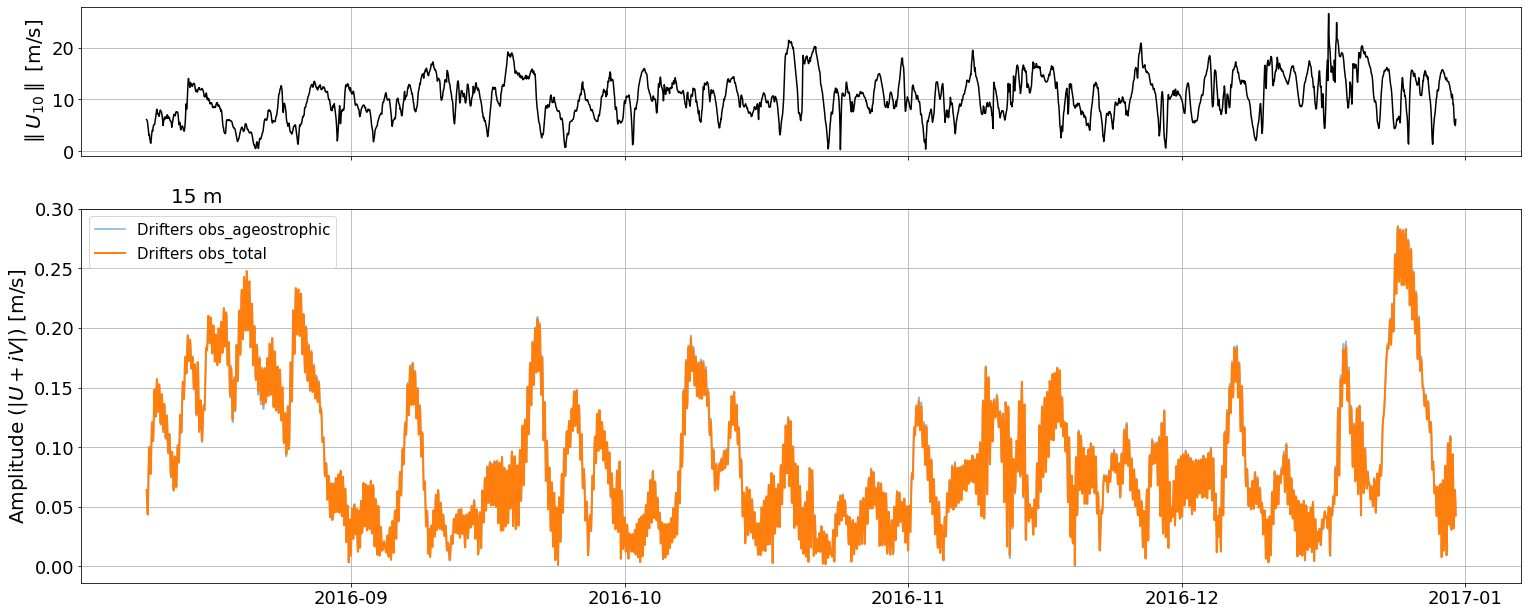

In [968]:
layers_p = np.array([0])
fields_compOb = [np.abs(Vnarrow_Q2t),np.abs(Vnarrow_Q2ag)]
fields_nameOb = ['Drifters obs_total','Drifters obs_ageostrophic']

               
plot_complex_layer_comp_drifter(W10wp[ii:ff],fields_compOb,fields_nameOb,dates[ii:ff],0,ff-ii,layers_p)
#plt.savefig('Amplitude_comp_winter.jpg', bbox_inches='tight')

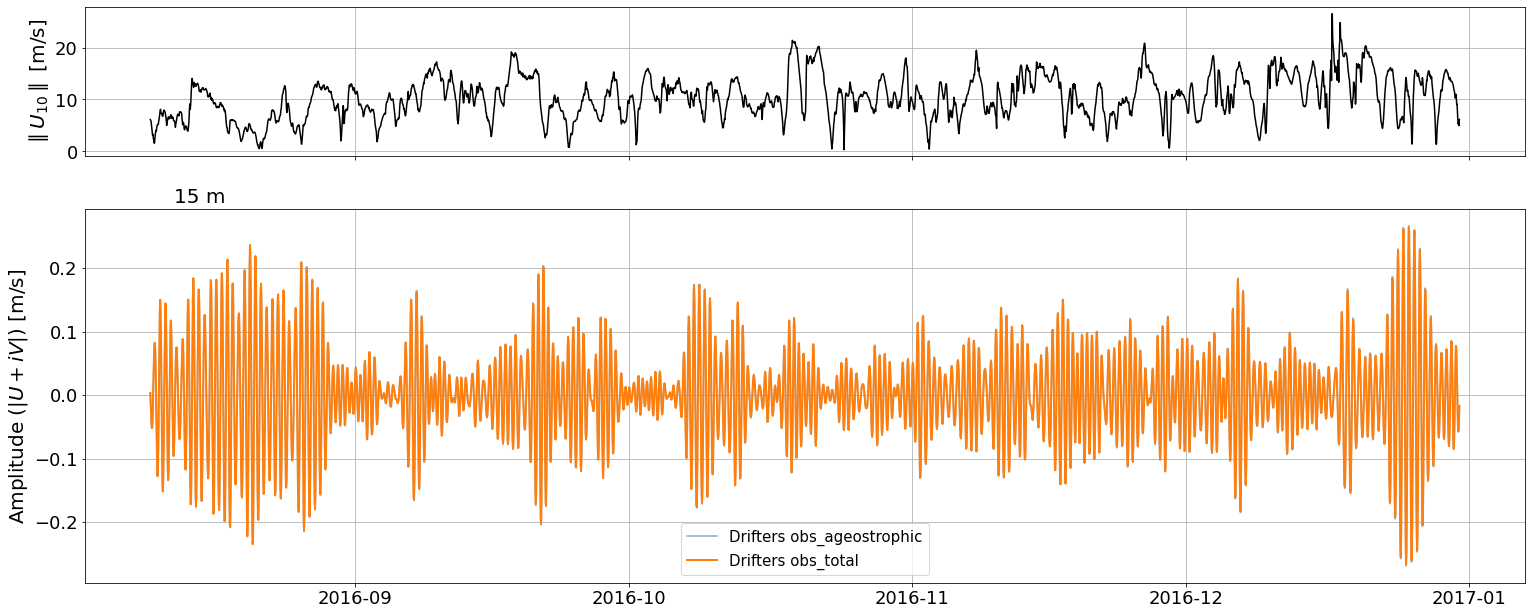

In [969]:
layers_p = np.array([0])
fields_compObU = [Ut_nfQ2,Uag_nfQ2]
fields_nameObU = ['Drifters obs_total','Drifters obs_ageostrophic']

               
plot_complex_layer_comp_drifter(W10wp[ii:ff],fields_compObU,fields_nameObU,dates[ii:ff],0,ff-ii,layers_p)
#plt.savefig('Amplitude_comp_winter.jpg', bbox_inches='tight')

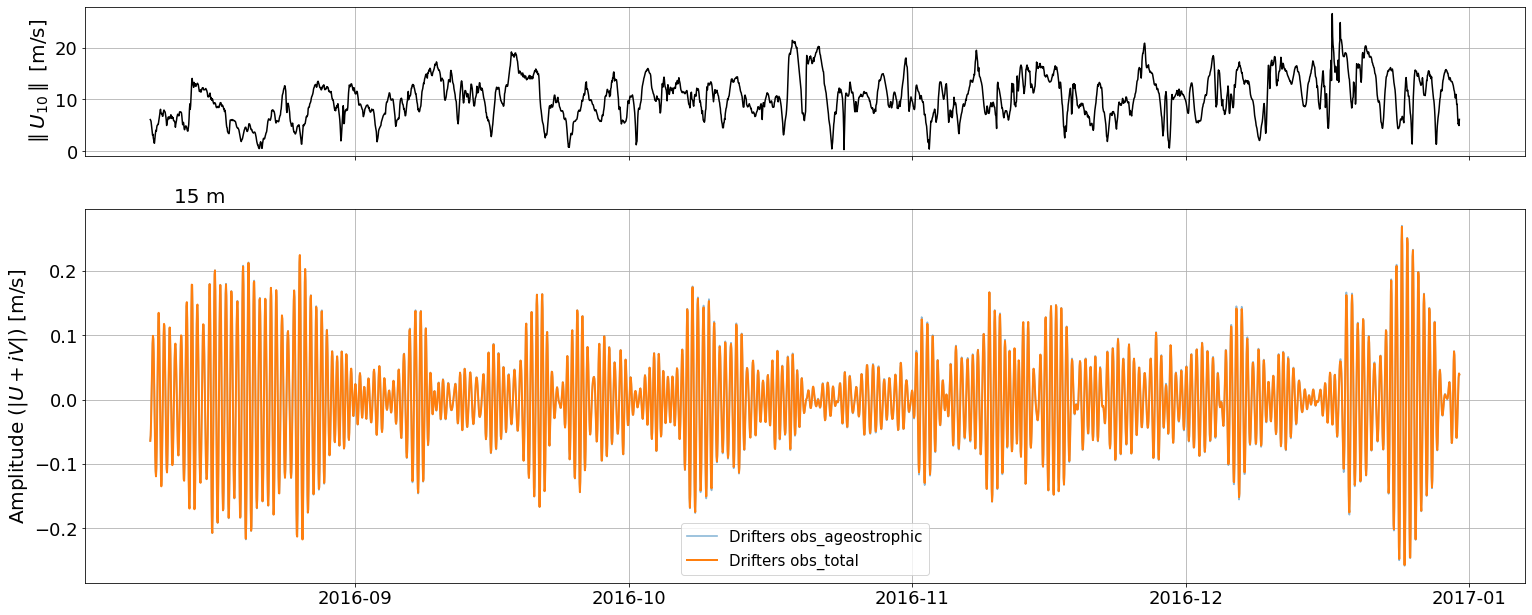

In [970]:
layers_p = np.array([0])
fields_compObV = [Vt_nfQ2,Vag_nfQ2]
fields_nameObV = ['Drifters obs_total','Drifters obs_ageostrophic']

               
plot_complex_layer_comp_drifter(W10wp[ii:ff],fields_compObV,fields_nameObV,dates[ii:ff],0,ff-ii,layers_p)
#plt.savefig('Amplitude_comp_winter.jpg', bbox_inches='tight')

### 6.3 IN_SITU OBSERVATIONS VS 1D MODEL - (after filtering)

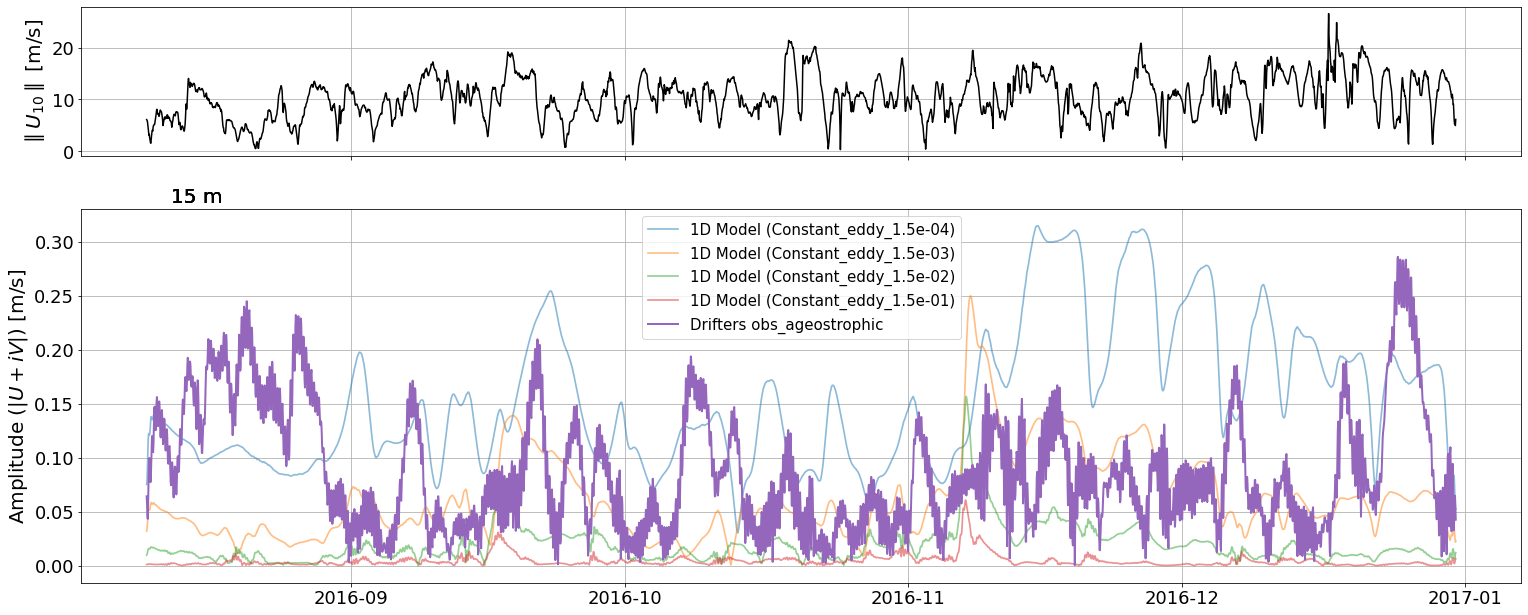

In [971]:
layers_p = np.array([0])
fields_comp = [np.abs(Vnarrow_Q2ag),np.abs(Vnarrow_Q2cel),np.abs(Vnarrow_Q2ce),np.abs(Vnarrow_Q2ceh),np.abs(Vnarrow_Q2cehh)]
fields_name = ['Drifters obs_ageostrophic','1D Model (Constant_eddy_1.5e-04)','1D Model (Constant_eddy_1.5e-03)','1D Model (Constant_eddy_1.5e-02)','1D Model (Constant_eddy_1.5e-01)']

               
plot_complex_layer_comp_drifter(W10wp[ii:ff],fields_comp,fields_name,dates[ii:ff],0,ff-ii,layers_p)
#plt.savefig('Amplitude_comp_winter.jpg', bbox_inches='tight')

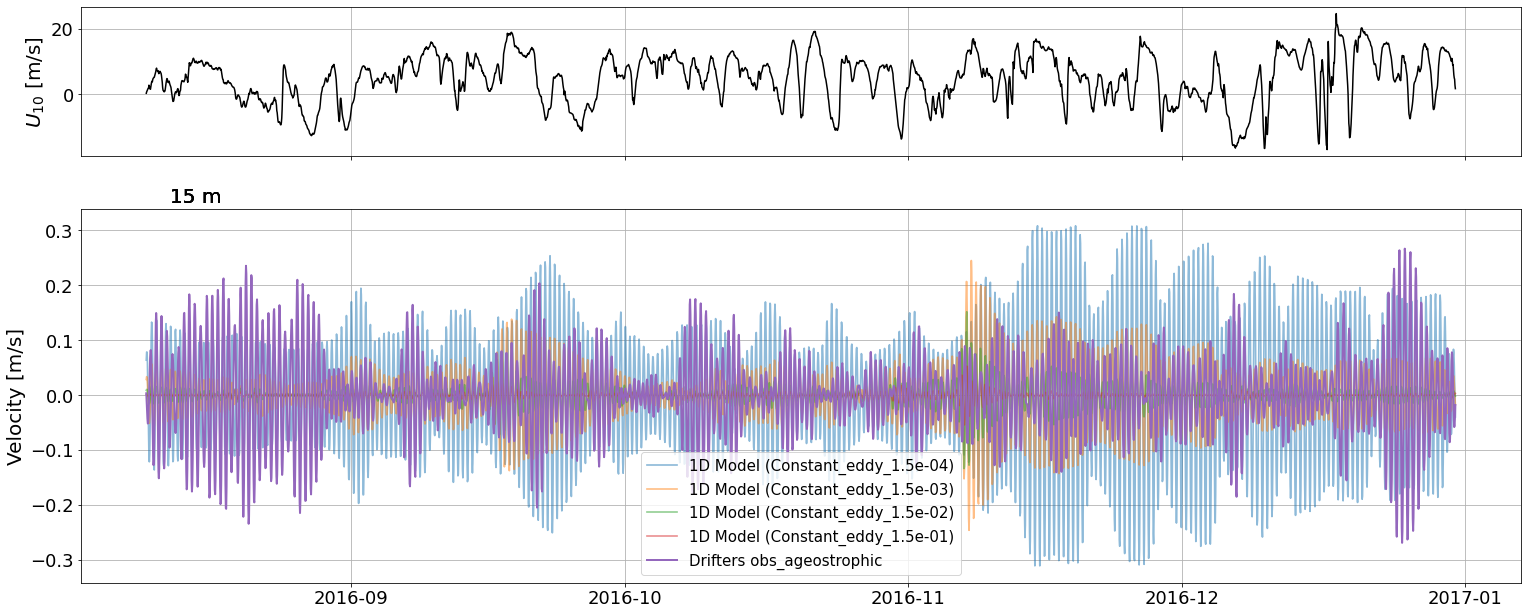

In [972]:
layers_p = np.array([0])
fields_compU = [Uag_nfQ2,Ucel_nfQ2,Uce_nfQ2,Uceh_nfQ2,Ucehh_nfQ2]
fields_nameU = ['Drifters obs_ageostrophic','1D Model (Constant_eddy_1.5e-04)','1D Model (Constant_eddy_1.5e-03)','1D Model (Constant_eddy_1.5e-02)','1D Model (Constant_eddy_1.5e-01)']
               
plot_layer_comp_drifter(U10wp[ii:ff],fields_compU,fields_nameU,dates[ii:ff],0,ff-ii,layers_p)
#plt.savefig('Amplitude_comp_winter.jpg', bbox_inches='tight')


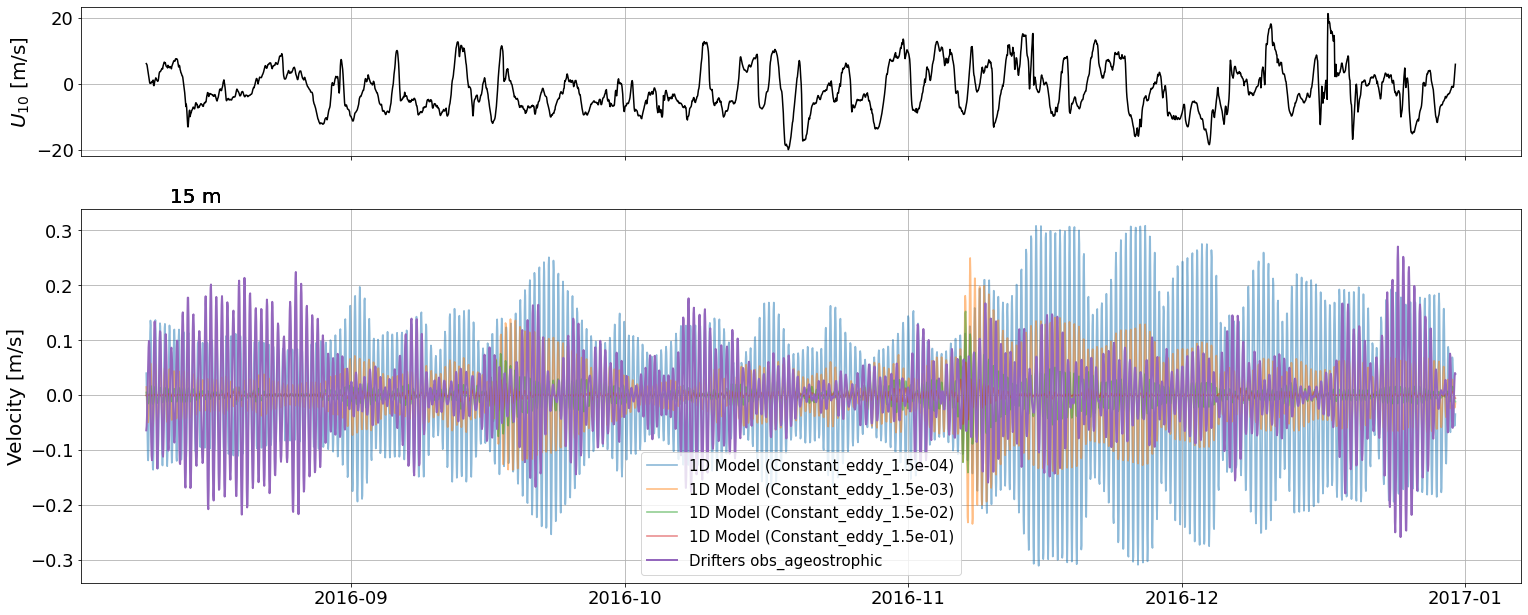

In [975]:
layers_p = np.array([0])
fields_compV = [Vag_nfQ2,Vcel_nfQ2,Vce_nfQ2,Vceh_nfQ2,Vcehh_nfQ2]
fields_nameV = ['Drifters obs_ageostrophic','1D Model (Constant_eddy_1.5e-04)','1D Model (Constant_eddy_1.5e-03)','1D Model (Constant_eddy_1.5e-02)','1D Model (Constant_eddy_1.5e-01)']

               
plot_layer_comp_drifter(V10wp[ii:ff],fields_compV,fields_nameV,dates[ii:ff],0,ff-ii,layers_p)
#plt.savefig('Amplitude_comp_winter.jpg', bbox_inches='tight')